# Wind Energy Analysis and Predictions (Using ARIMA)

Coded by Luna McBride

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot") #Define the style of the plot

from statsmodels.tsa.stattools import adfuller #Check if data is stationary
from statsmodels.graphics.tsaplots import plot_acf #Compute lag for ARIMA
from statsmodels.graphics.tsaplots import plot_pacf #Compute partial lag for ARIMA
from statsmodels.tsa.arima.model import ARIMA #Predictions and Forecasting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-power-generation/TenneTTSO.csv
/kaggle/input/wind-power-generation/50Hertz.csv
/kaggle/input/wind-power-generation/TransnetBW.csv
/kaggle/input/wind-power-generation/Amprion.csv


In [2]:
companies = ["50Hertz", "Amprion", "TenneTTSO", "TransnetBW"] #Get the company names into a list
path = "../input/wind-power-generation/" #Get the path to the company CSVs
dataframeHolder = [] #Create a list to hold all of the dataframes

#For each company, collect the CSVs
for comp in companies:
    compPath = path + comp + ".csv" #Build the path to the CSV
    compDF = pd.read_csv(compPath) #Read the CSV for the company
    dataframeHolder.append(compDF) #Put the company CSV into the dataframe holder
    
dataframeHolder[0].head() #Show the head of the first dataset

,Date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
0,23/08/2019,74,73,63,55,54,53,51,52,45,...,68,68,63,61,57,52,51,49,45,40
1,24/08/2019,37,38,35,35,31,32,30,29,28,...,118,118,112,107,104,104,99,95,95,96
2,25/08/2019,93,88,85,81,76,80,81,76,73,...,111,108,103,96,93,88,86,82,80,77
3,26/08/2019,72,66,59,54,48,46,45,43,42,...,48,47,47,46,47,49,50,51,48,42
4,27/08/2019,39,38,36,36,34,31,31,30,31,...,54,53,51,52,51,52,54,54,56,59


---

# Melt and Combine the Dataframes

## Melt the Dataframes

Reference to the melt technique in this notebook: https://www.kaggle.com/ggopinathan/german-wind-power-generation-eda

In [3]:
#MeltComp: melts the wide time columns into a single datetime row
#Input: The company dataframe, the company name
#Output: The melted dataframe
def meltComp(compDF, comp):
    df = pd.melt(compDF, id_vars = ["Date"], var_name = "Time", value_name = comp) #Melt the dataframe by date and time
    df["dateTime"] = df["Date"] + " " +df["Time"] #Create a combined datetime column
    df["dateTime"] = pd.to_datetime(df["dateTime"]) #Turn the datetime column into a datetime type

    df = df.drop(columns = {"Date", "Time"}) #Drop the date and time columns (they are now redundant)
    df = df.set_index("dateTime") #Set the index to the new dateTime column
    df = df.sort_index() #Sort them based on index so that the dates are grouped together
    df.reset_index(drop = False, inplace = True) #Reset the index
    return df #Return the new dataframe

In [4]:
meltDF = [] #Create another holder for melted dataframes
compIterator = 0 #Create an iterator for the company names

#For each company dataframe, melt it down. We want the times to be rows, not columns.
for compDF in dataframeHolder:
    meltDF.append(meltComp(compDF, companies[compIterator])) #Melt the company dataframe and add it to the melted dataframe holder
    compIterator += 1 #Increase the company name iterator

meltDF[0].head() #Show one of the melted dataframes

,dateTime,50Hertz
0,2019-01-09 00:00:00,163
1,2019-01-09 00:15:00,138
2,2019-01-09 00:30:00,130
3,2019-01-09 00:45:00,122
4,2019-01-09 01:00:00,117


## Combine the Dataframes

In [5]:
mainDF = meltDF[0] #Get the first DF as the one to merge on
meltLength = len(meltDF) #Get the number of melted dataframe

#For each company in meltDF, merge the dataframe with the main one (start at 1 to ignore the original main one)
for company in range(1, meltLength):
    mainDF = mainDF.merge(meltDF[company], on = "dateTime") #Merge the company dataframes with the main one

mainDF = mainDF.set_index("dateTime") #Set the index to dateTime
mainDF = mainDF.asfreq(freq = "15T", fill_value = 0) #Set the frequency to every 15 minutes
mainDF.head() #Take a peek at the new dataframe

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-01-09 00:00:00,163,107,100.52,51.53
2019-01-09 00:15:00,138,119,85.97,55.23
2019-01-09 00:30:00,130,112,77.25,49.09
2019-01-09 00:45:00,122,101,68.23,52.78
2019-01-09 01:00:00,117,101,62.82,49.55


In [6]:
len(mainDF.index) #Get the number of rows

67296

---

# Check for Null Values

In [7]:
print(mainDF.isnull().any()) #Check for any null values
print(mainDF.describe()) #Describe the dataset

50Hertz       False
Amprion       False
TenneTTSO     False
TransnetBW    False
dtype: bool
            50Hertz       Amprion     TenneTTSO    TransnetBW
count  67296.000000  67296.000000  67296.000000  67296.000000
mean      81.329945     55.370215     83.084485     17.072374
std      125.940665     87.739669    130.537570     30.846155
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%       22.000000     11.000000     21.250000      2.000000
75%      113.000000     75.000000    111.072500     20.780000
max      725.000000    463.000000    727.440000   1506.780000


There are no null values. The values also range from 0, meaning there are no -1's that are replacing null values or anything of the sort.

---

# Quick Visualization/Analysis

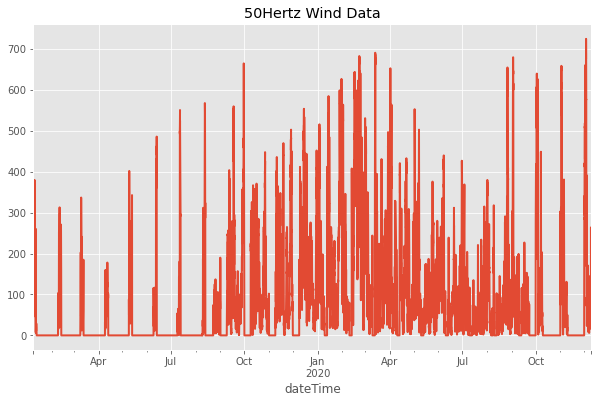

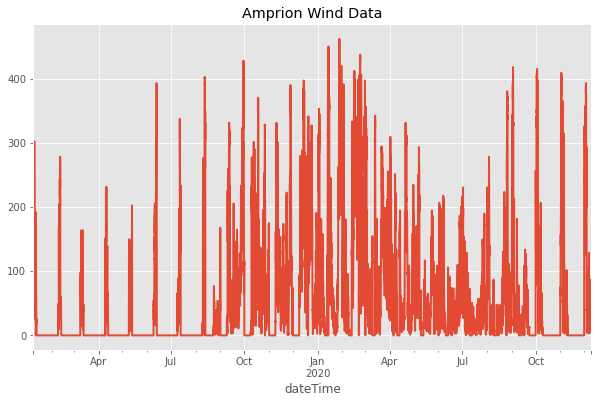

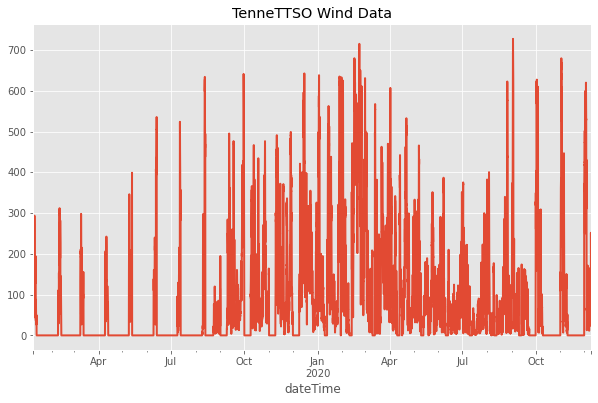

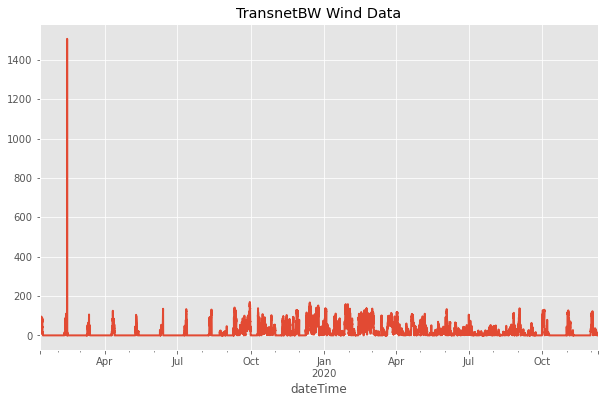

In [8]:
plt.rcParams["figure.figsize"] = (10,6) #Fix the graph sizes
columns = mainDF.columns #Get the columns to show

#For each company, plot the wind data
for col in columns:
    plt.figure() #Construct the figure so it gives each a separate graph
    mainDF[col].plot(title = col + " Wind Data") #Plot the company wind data

In [9]:
print(mainDF.loc[mainDF["TransnetBW"] > 200]) #Show the range of the TransnetBW anomoly

                     50Hertz  Amprion  TenneTTSO  TransnetBW
dateTime                                                    
2019-02-12 08:00:00      130       57     111.22      600.59
2019-02-12 09:00:00      140       56     114.95     1008.15
2019-02-12 10:00:00      154       54     112.71     1324.77
2019-02-12 11:00:00      170       48     109.94     1506.78
2019-02-12 12:00:00      181       41     122.95     1238.06
2019-02-12 13:00:00      195       47     138.67      796.74
2019-02-12 14:00:00      210       41     145.29      287.91


In [10]:
mainDF.loc[mainDF.index == "2019-03-15 00:15:00"] #Show a date where it was empty, and thus filled with 0

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-03-15 00:15:00,0,0,0.0,0.0


This dataset not only has some missing data (represented by the flat lines at 0, as I filled them in previously), but also a pretty significant anomoly for TransnetBW on February 12th, 2019.

Overall, 50Hertz and TenneTTSO appear to register in windier areas, with Amprion in a less windy area and TransnetBW being in an area with very low wind (with exception to that anomoly registered on February 12th, 2019). The wind patterns are relatively flat with very little seasonality (I will still test to see if adfuller agrees, though). The only issue I can see is that anomoly, but I will leave it be for now. 

Another note is that there is over 60000 rows due to the sampling every 15 minutes. I tried working with this how it is, but I could not even run one ARIMA model without it taking up all of the memory. For this case, I will try making this a daily mean, reducing the datapoints from over 60000 to around 700.

---

# Resample to Daily Wind Measures

Documentation on Resampling: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [11]:
mainDF = mainDF.resample("D").mean() #Change the data to get the daily wind energy means
mainDF.head() #Take a peek at the dataset

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-01-09,111.322917,46.583333,90.469583,28.946771
2019-01-10,239.552083,192.802083,171.260729,64.777604
2019-01-11,195.281250,125.281250,154.351875,37.831562
2019-01-12,16.395833,58.500000,47.354271,38.509062
2019-01-13,0.000000,0.000000,0.000000,0.000000


In [12]:
len(mainDF.index) #Get the number of rows

701

That should work much better.

---

# ADFuller Testing

In [13]:
#For each column, perform the ADFuller test
for col in columns:
    print("ADFuller Test; Significance: 0.05. Company: {}".format(col)) #Print the significance level
    adf = adfuller(mainDF[col]) #Call adfuller to test
    print("ADF test static for {} is {}".format(col, adf[1])) #Print the adfuller results

ADFuller Test; Significance: 0.05. Company: 50Hertz
ADF test static for 50Hertz is 2.2852723445873237e-24
ADFuller Test; Significance: 0.05. Company: Amprion
ADF test static for Amprion is 1.7075617055665183e-18
ADFuller Test; Significance: 0.05. Company: TenneTTSO
ADF test static for TenneTTSO is 8.97042967747912e-16
ADFuller Test; Significance: 0.05. Company: TransnetBW
ADF test static for TransnetBW is 1.97687779028105e-19


ADFuller agrees that these are already flat.

---

# Get the P and Q lags

## AR (P)

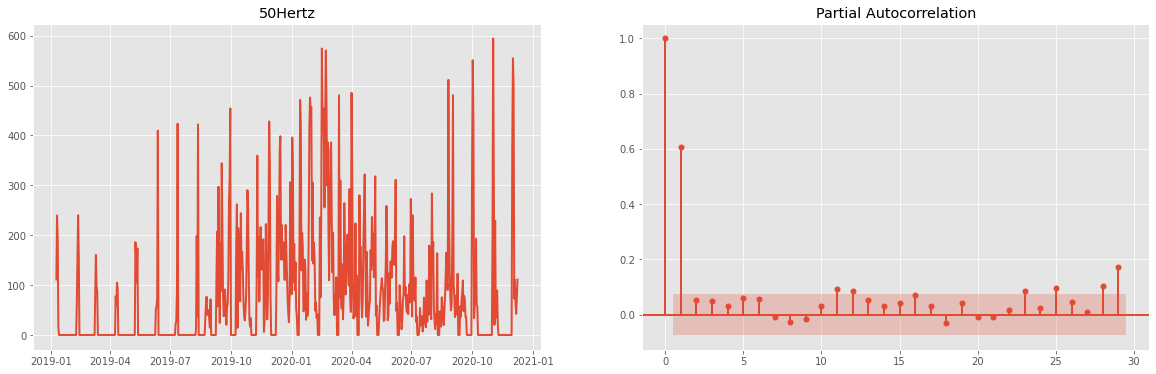

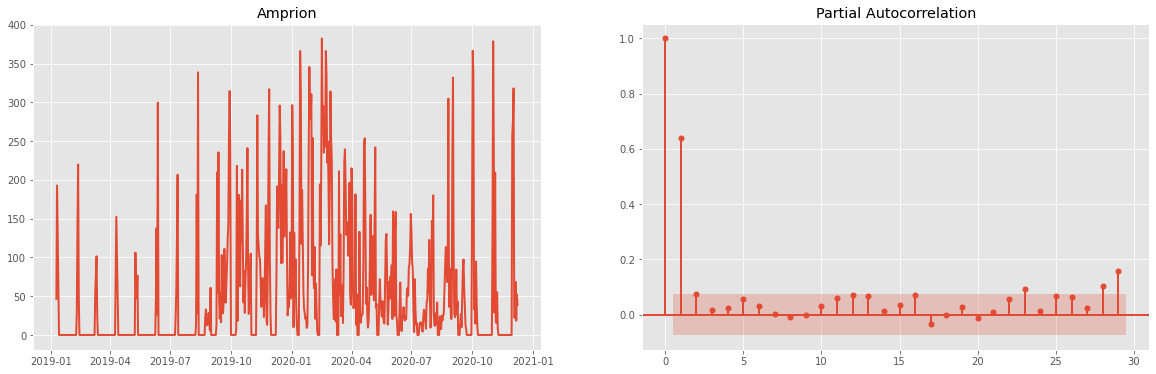

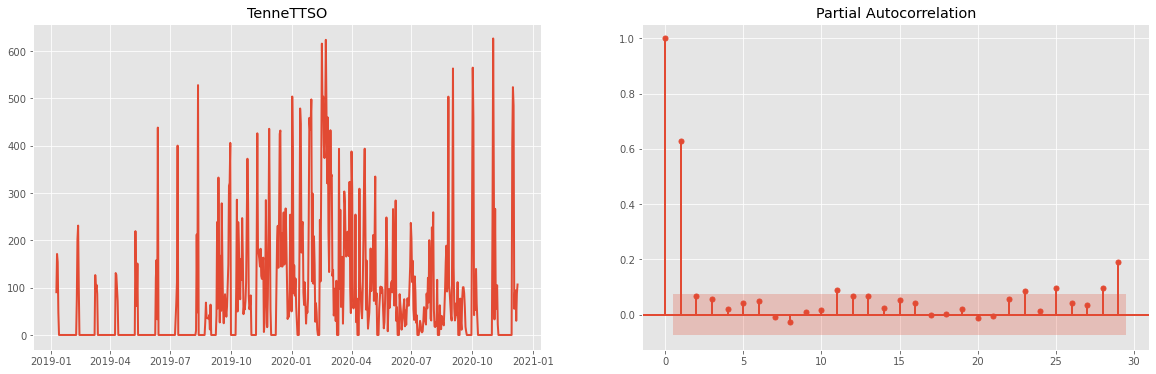

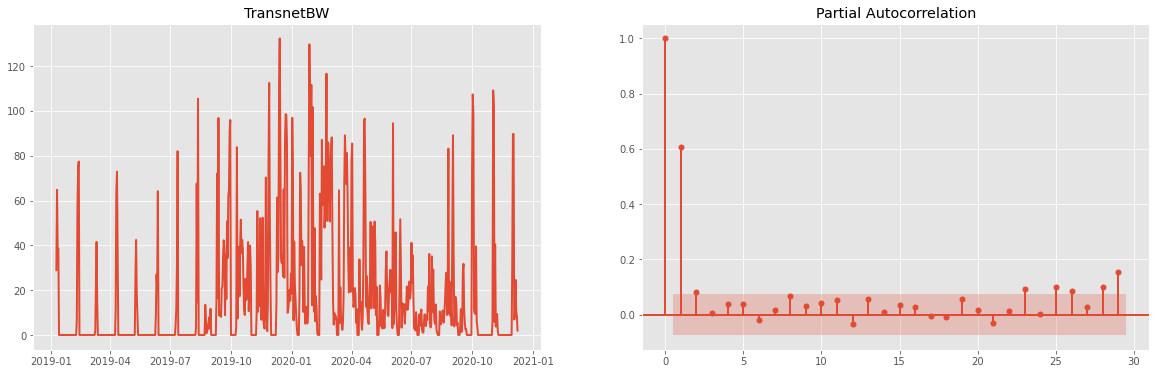

In [14]:
plt.rcParams["figure.figsize"] = (20,6) #Fix the graph size

#For each company, graph the data and get a p value
for comp in companies:
    fig,axes = plt.subplots(1,2) #Create a subplot for the Partial ACF
    a = axes[0].plot(mainDF[comp]) #Plot one company's data
    a = axes[0].set_title(comp) #Ensure the data is named
    b = plot_pacf(mainDF[comp], ax = axes[1], method = "ols") #Plot the partial ACF

5 seems to be a fair p value for all graphs.

## MA (Q)

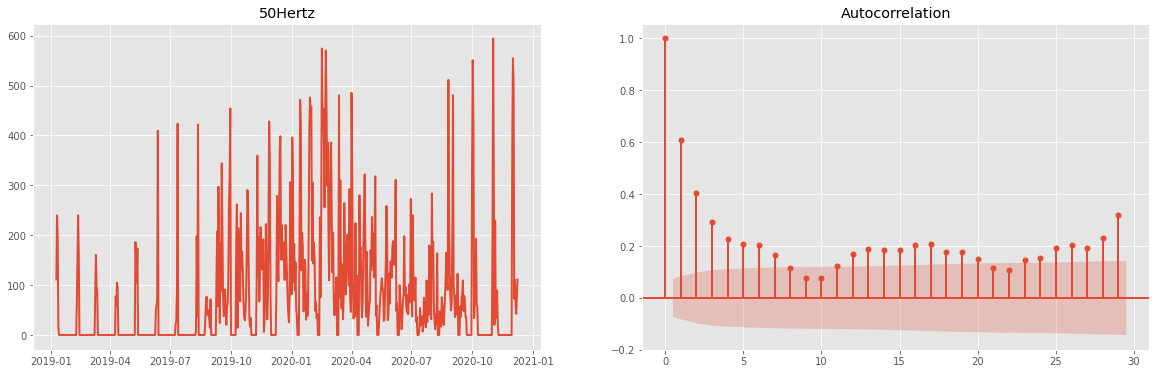

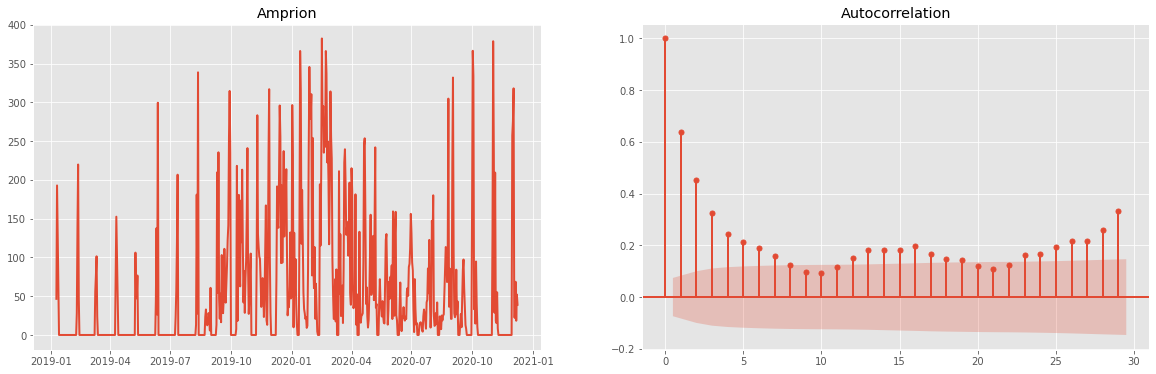

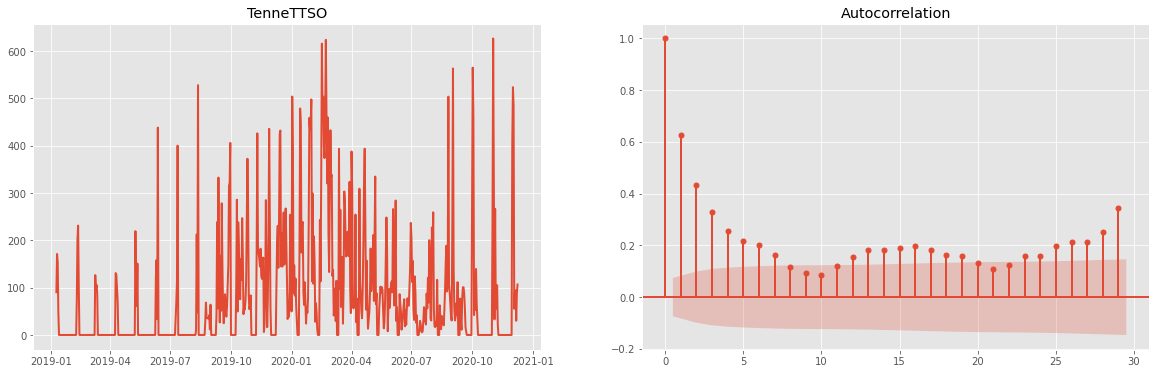

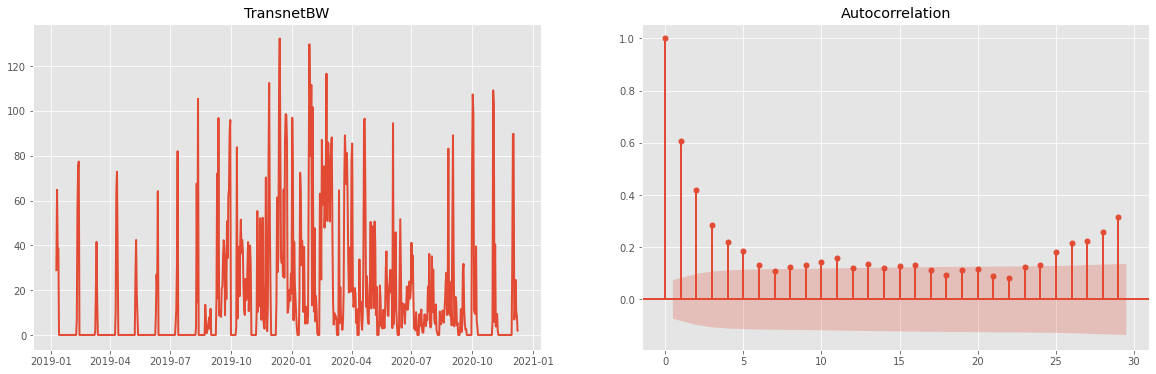

In [15]:
#For each company, graph the data and get a q value
for comp in companies:
    fig,axes = plt.subplots(1,2) #Create a subplot for the ACF
    a = axes[0].plot(mainDF[comp]) #Plot one company's data
    a = axes[0].set_title(comp) #Ensure the data is named
    b = plot_acf(mainDF[comp], ax = axes[1]) #Plot the ACF

None of these really fit all too well. I will go with 8, since it is the lowest with them in the red interval.

---

# Train the Model

Note: this could all be in one loop to lower processing need. I just wanted them to be separate.

In [16]:
models = [] #Create a list for the models

#For loop to run an ARIMA model for each company
for col in columns:
    model = ARIMA(mainDF[col], order = (5, 1, 8)) #Build the ARIMA model
    fitModel = model.fit() #Fit the ARIMA model
    models.append(fitModel) #Put the fit model into the models list

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


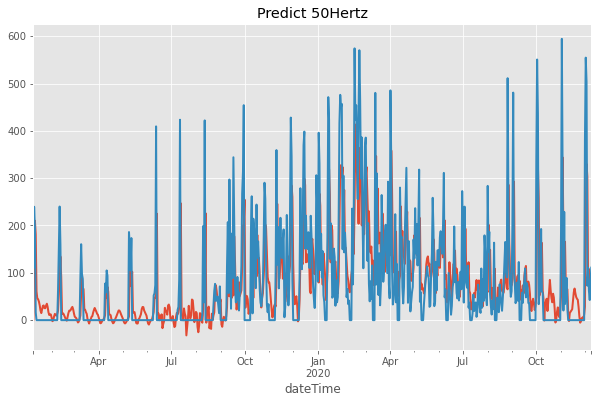

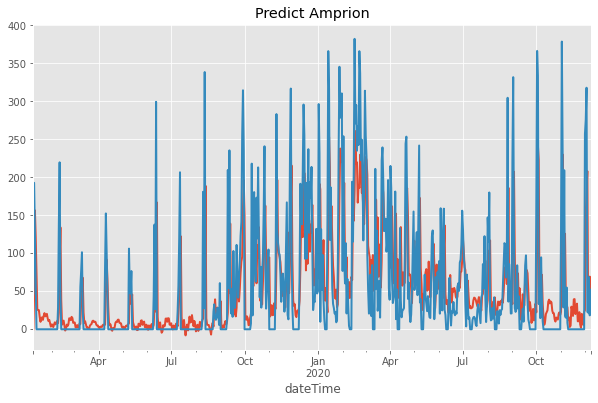

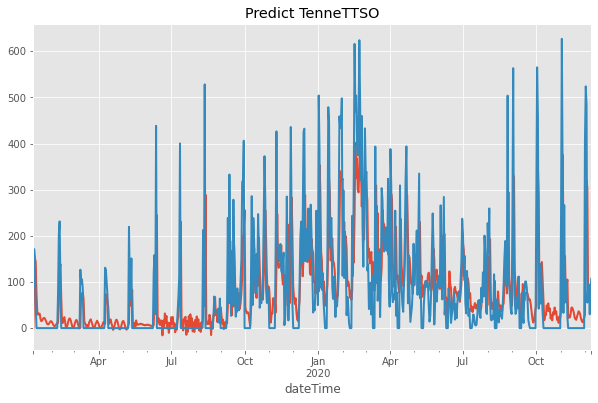

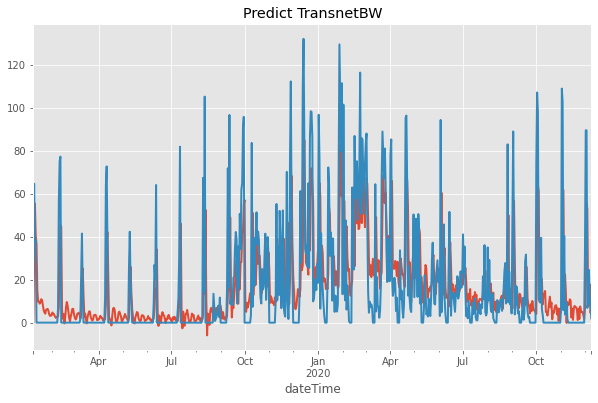

In [17]:
plt.rcParams["figure.figsize"] = (10,6) #Fix the graph size
modelIterator = 0 #An iterator to line up the ARIMA models

#For loop to plot ARIMA predictions with the originals
for col in columns:
    plt.figure() #Reset onto a new graph
    predict = models[modelIterator].predict() #Predict the model outcome
    predict.plot(title = "Predict {}".format(col)) #Plot the predictions
    mainDF[col].plot() #Plot the original
    plt.show() #Show the ARIMA plot
    
    modelIterator += 1 #Add one to the iterator

These seem to make fair predictions based on what they are given. The large gaps in the data are filled with interesting small predictions instead of predicting 0. This is also likely why it goes negative sometimes. I would like to see how it decides to predict the future based on this.

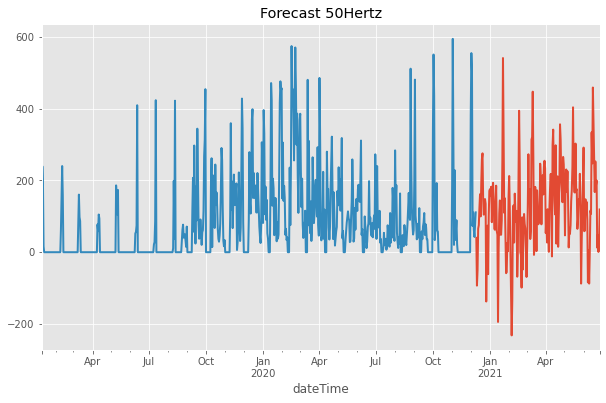

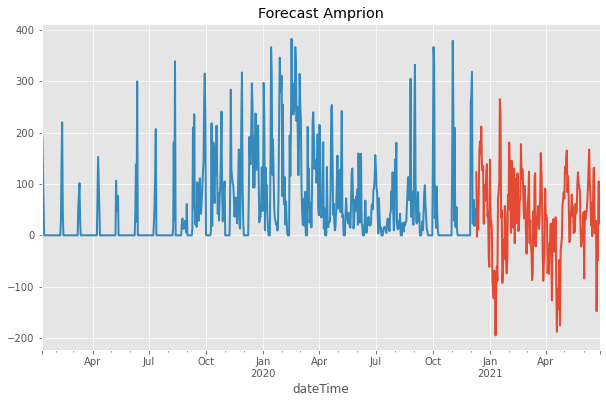

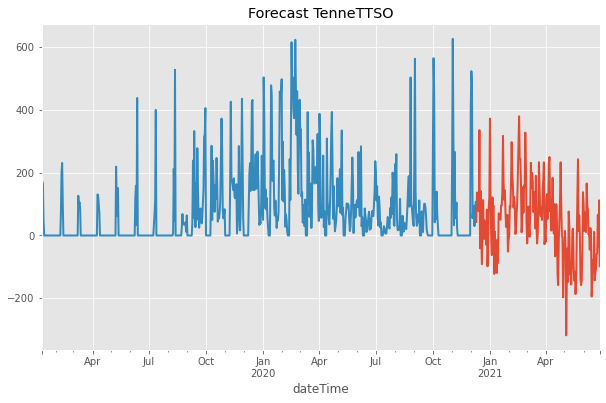

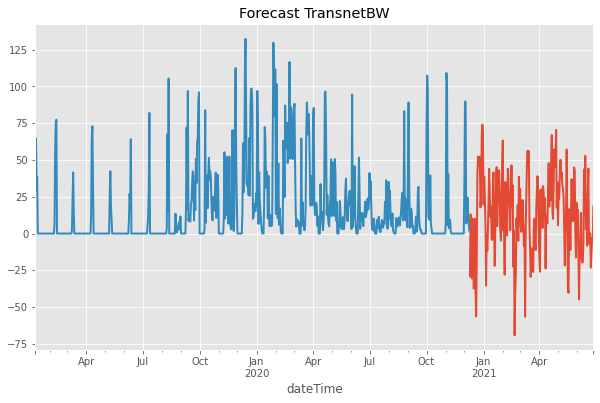

In [18]:
plt.rcParams["figure.figsize"] = (10, 6) #Fix the graph size

modelIterator = 0 #An iterator to line up the ARIMA models

#For loop to plot ARIMA predictions with the originals
for col in columns:
    plt.figure() #Reset onto a new graph
    predict = models[modelIterator].simulate(200, anchor = "end") #Predict the future outcomes
    predict.plot(title = "Forecast {}".format(col)) #Plot the predictions
    mainDF[col].plot() #Plot the original
    plt.show() #Show the ARIMA plot
    
    modelIterator += 1 #Add one to the iterator

It seems the empty 0 data made the predictions trend lower, even going pretty far negative at times. I think I will try this again with the ARIMA's drop null functionality instead.

---

# Do the Model with NAN

In [19]:
mainNA = mainDF.copy() #Make a copy to have with NANs
mainNA.head() #Take a peek at this dataset

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-01-09,111.322917,46.583333,90.469583,28.946771
2019-01-10,239.552083,192.802083,171.260729,64.777604
2019-01-11,195.281250,125.281250,154.351875,37.831562
2019-01-12,16.395833,58.500000,47.354271,38.509062
2019-01-13,0.000000,0.000000,0.000000,0.000000


In [20]:
#For each column, make all 0's into NAN
for col in columns:
    mainNA[col] = mainNA[col].apply(lambda x: np.nan if x == 0 else x) #Change 0 to NAN
    
mainNA.loc[mainNA.index == "2019-01-13"] #Show a date where it was empty, and thus filled with NAN

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-01-13,NaN,NaN,NaN,NaN


In [21]:
modelsNA = [] #Create a list for the models

#For loop to run an ARIMA model for each company
for col in columns:
    model = ARIMA(mainNA[col], order = (5, 1, 8), missing = "drop") #Build the ARIMA model
    fitModel = model.fit() #Fit the ARIMA model
    modelsNA.append(fitModel) #Put the fit model into the models list

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib

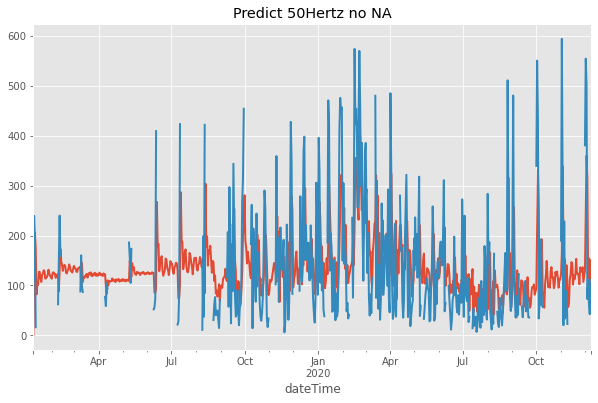

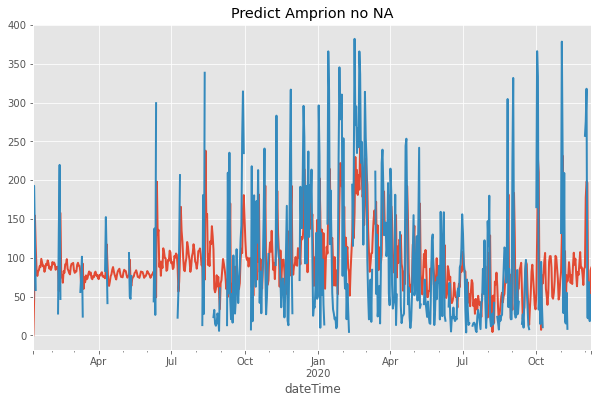

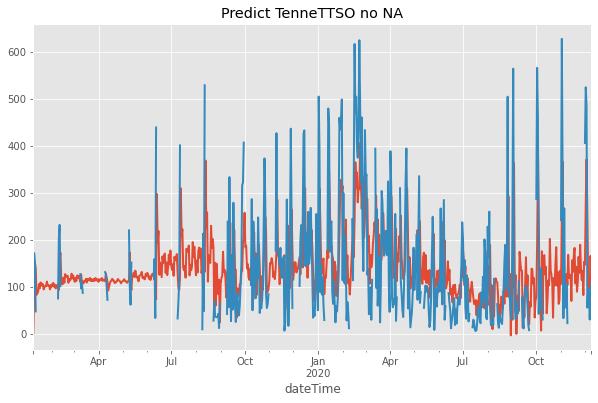

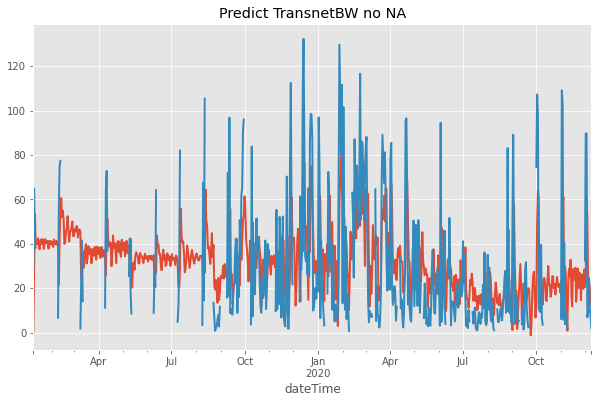

In [22]:
plt.rcParams["figure.figsize"] = (10,6) #Fix the graph size
modelIterator = 0 #An iterator to line up the ARIMA models

#For loop to plot ARIMA predictions with the originals
for col in columns:
    plt.figure() #Reset onto a new graph
    predictNA = modelsNA[modelIterator].predict() #Predict the model outcome
    predictNA.plot(title = "Predict {} no NA".format(col)) #Plot the predictions
    mainNA[col].plot() #Plot the original
    plt.show() #Show the ARIMA plot
    
    modelIterator += 1 #Add one to the iterator

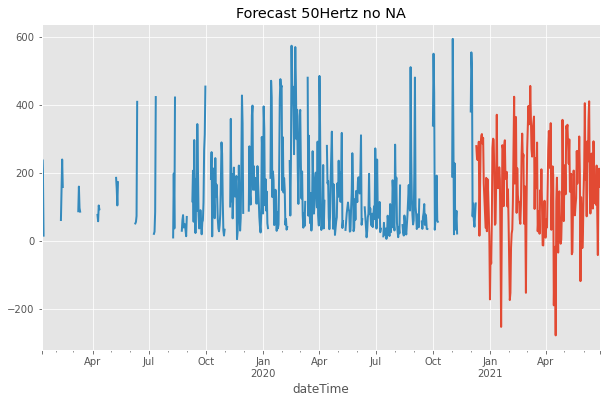

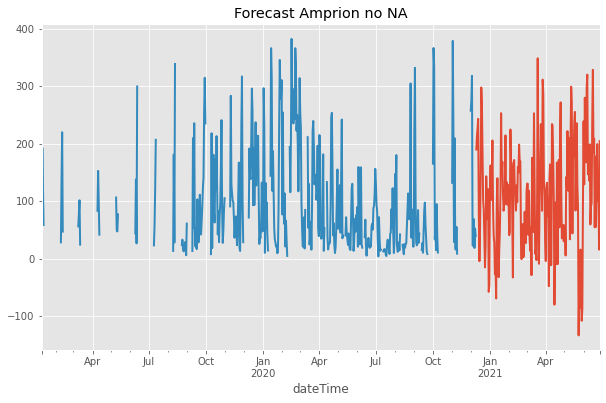

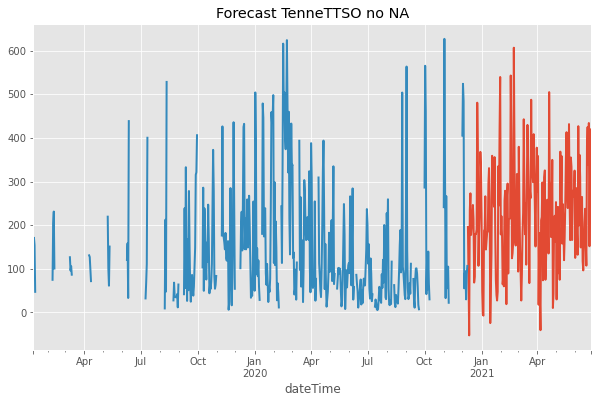

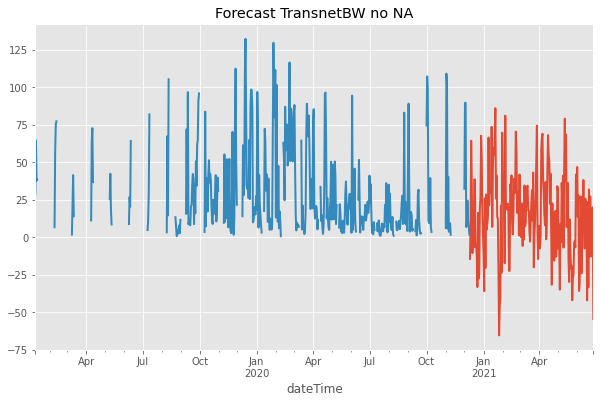

In [23]:
plt.rcParams["figure.figsize"] = (10, 6) #Fix the graph size

modelIterator = 0 #An iterator to line up the ARIMA models

#For loop to plot ARIMA predictions with the originals
for col in columns:
    plt.figure() #Reset onto a new graph
    predictNA = modelsNA[modelIterator].simulate(200, anchor = "end") #Predict the future outcomes
    predictNA.plot(title = "Forecast {} no NA".format(col)) #Plot the predictions
    mainNA[col].plot() #Plot the original
    plt.show() #Show the ARIMA plot
    
    modelIterator += 1 #Add one to the iterator

The negative values are not as bad with dropped nulls. The model fills the blanks with more middle values when predicting the given data. The forecasts are then pulled up like I predicted, telling me the 0's were pulling the forecasts down. It really shows how much this dataset is missing, which could also be making the forecasts have negative points. I am happy with these forecasts despite this.